In [ ]:
# ===============================
# Project: Cardiovascular Disease Prediction
# End-to-end Google Colab Notebook
# ===============================

# !pip installs (uncomment if needed)
# !pip install scikit-learn==1.5.1 seaborn==0.13.2 matplotlib==3.8.4 imbalanced-learn==0.12.3

import os
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay,
                             ConfusionMatrixDisplay, classification_report)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
import joblib

RANDOM_STATE = 42
sns.set(context="notebook", style="whitegrid")
pd.set_option('display.max_columns', 100)


In [ ]:
# ===== Option A: Upload the CSV from your computer (run this cell, then pick the file)
from google.colab import files

CSV_PATH = None  # set to a path string if you have it already (Option B)
if CSV_PATH is None:
    uploaded = files.upload()  # choose e.g. "cardio_train.csv" or "cardio_train (1).csv"
    assert len(uploaded) == 1, "Please upload exactly one file."
    CSV_PATH = list(uploaded.keys())[0]

print("Using file:", CSV_PATH)

# Dataset uses semicolon separator
df = pd.read_csv(CSV_PATH, sep=';')
print(df.shape)
df.head()


Saving cardio_train (1).csv to cardio_train (1).csv
Using file: cardio_train (1).csv
(70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [ ]:
# Inspect schema and target balance
print(df.info())
print(df['cardio'].value_counts(normalize=True).rename('proportion').round(3))

# Rename columns (optional readability)
df = df.rename(columns={
    'ap_hi': 'ap_sys',
    'ap_lo': 'ap_dia'
})

# Age is in days → convert to years (float) and an integer 'age_years'
df['age_years'] = (df['age'] / 365.25).round(1)
df['age_years_int'] = (df['age'] / 365.25).astype(int)

# Create useful derived features
df['bmi'] = df['weight'] / (df['height']/100)**2
df['overweight'] = (df['bmi'] >= 25).astype(int)
df['obese'] = (df['bmi'] >= 30).astype(int)
df['pulse_pressure'] = df['ap_sys'] - df['ap_dia']
df['bp_flag_sys_high'] = (df['ap_sys'] >= 140).astype(int)
df['bp_flag_dia_high'] = (df['ap_dia'] >= 90).astype(int)

# Remove impossible / extreme values (basic sanity rules)
# - height outside [120, 220] cm
# - weight outside [30, 200] kg
# - systolic/diastolic swapped or non-physiological
before = len(df)
df = df[(df['height'].between(120, 220)) &
        (df['weight'].between(30, 200)) &
        (df['ap_sys'].between(70, 250)) &
        (df['ap_dia'].between(40, 200)) &
        (df['ap_sys'] >= df['ap_dia'])]
after = len(df)
print(f"Removed {before - after} rows due to obvious outliers / impossible values.")

# Check missing values
print(df.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB
None
cardio
0    0.5
1    0.5
Name: proportion, dtype: float64
Removed 1383 rows due to obvious outliers / impossible values.
id                  0
age                 0
gender              0
height            

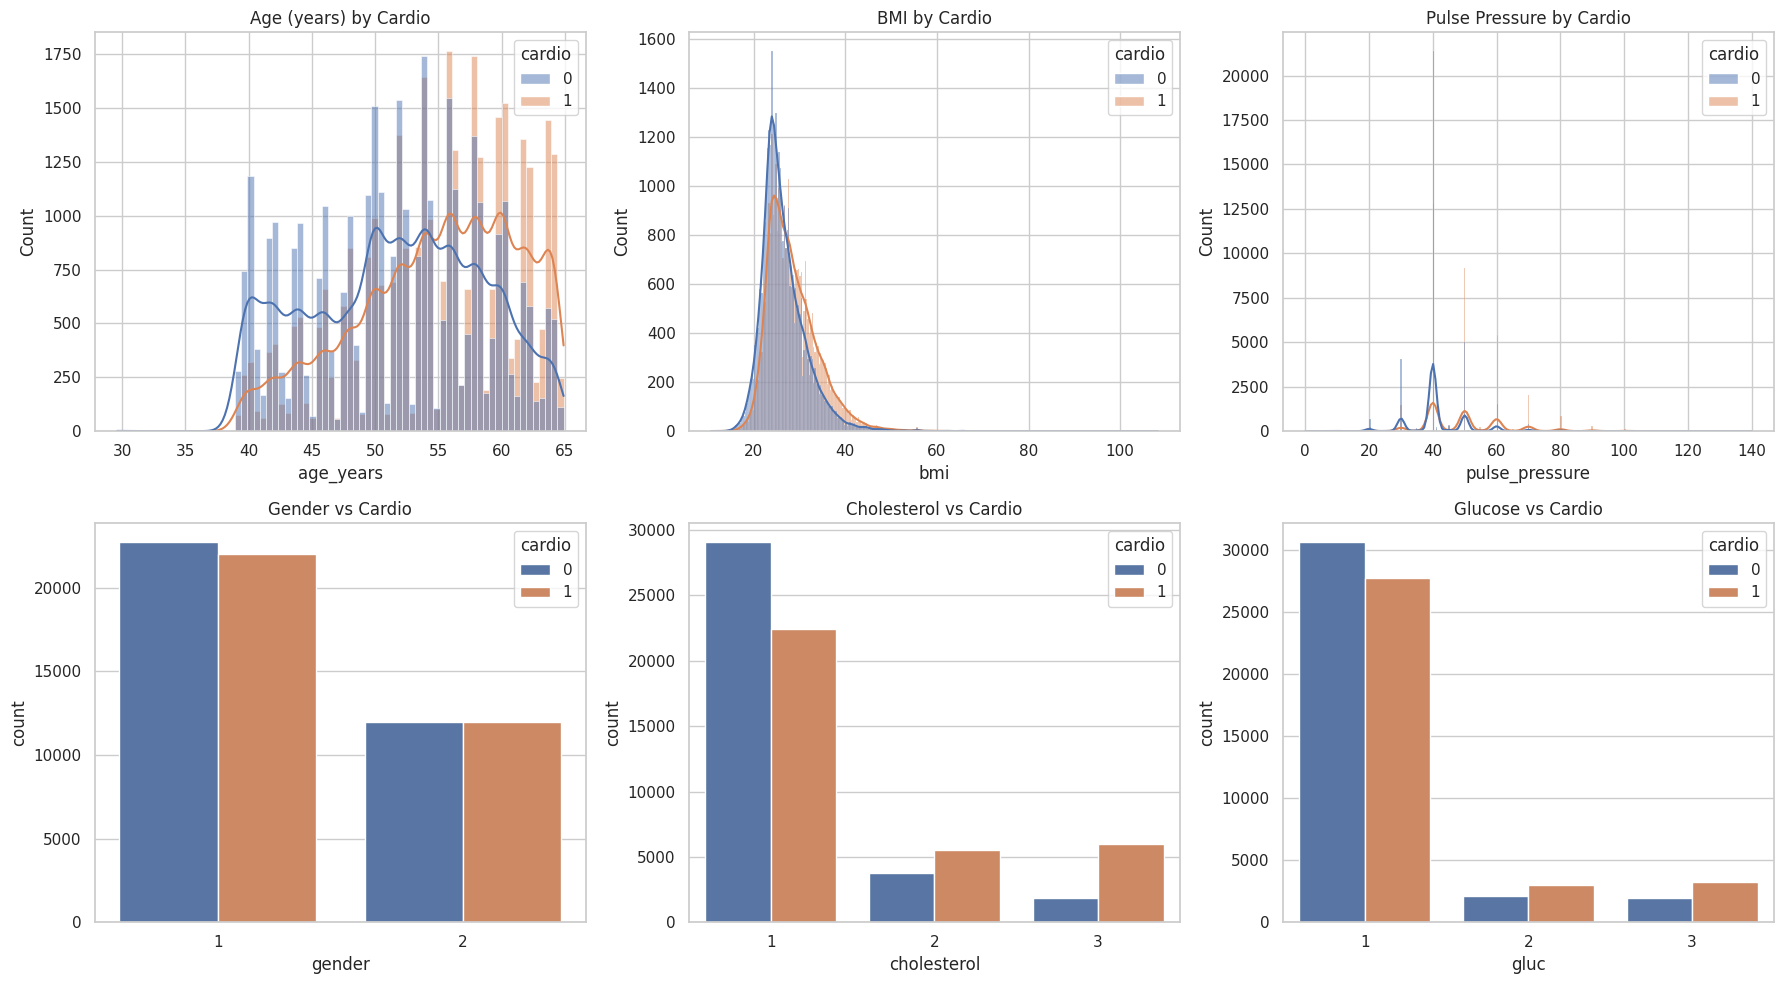

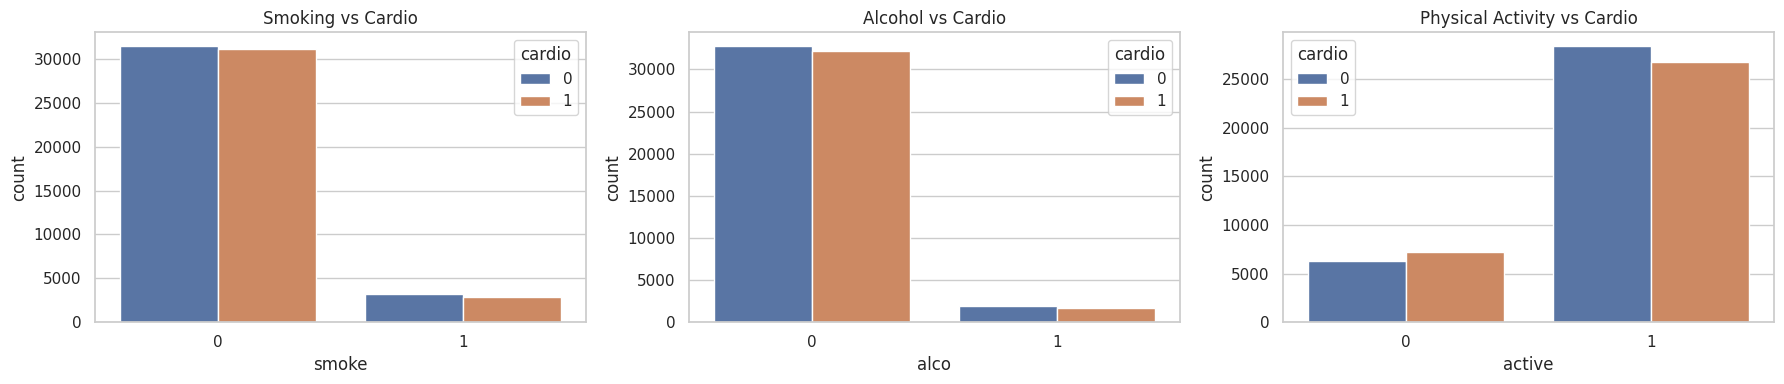

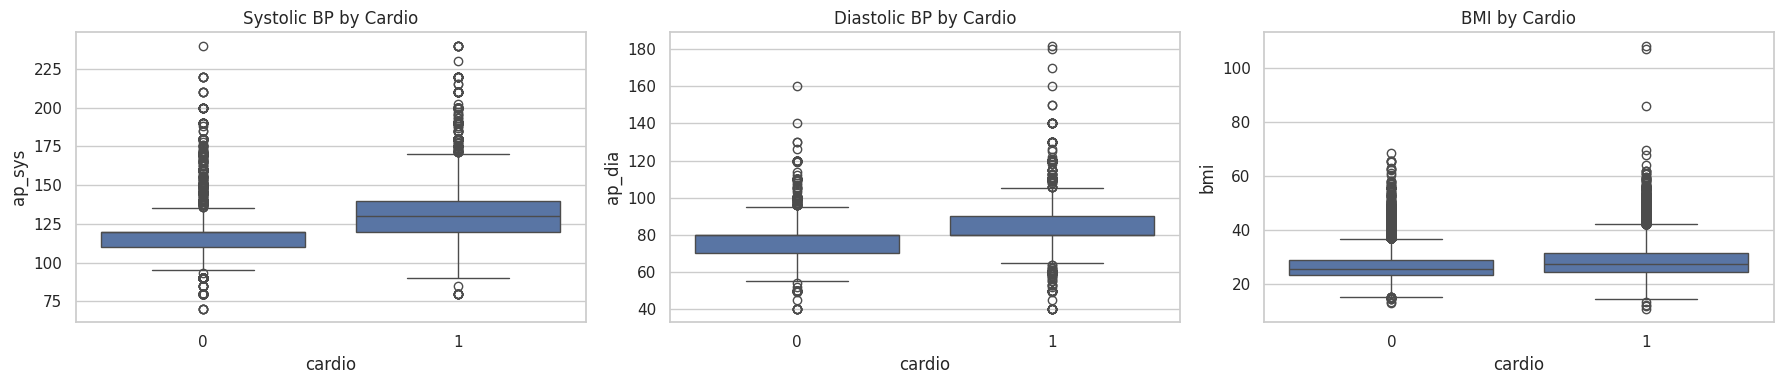

In [ ]:
# Distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
sns.histplot(df, x='age_years', hue='cardio', kde=True, ax=axes[0,0])
axes[0,0].set_title('Age (years) by Cardio')

sns.histplot(df, x='bmi', hue='cardio', kde=True, ax=axes[0,1])
axes[0,1].set_title('BMI by Cardio')

sns.histplot(df, x='pulse_pressure', hue='cardio', kde=True, ax=axes[0,2])
axes[0,2].set_title('Pulse Pressure by Cardio')

sns.countplot(df, x='gender', hue='cardio', ax=axes[1,0])
axes[1,0].set_title('Gender vs Cardio')

sns.countplot(df, x='cholesterol', hue='cardio', ax=axes[1,1])
axes[1,1].set_title('Cholesterol vs Cardio')

sns.countplot(df, x='gluc', hue='cardio', ax=axes[1,2])
axes[1,2].set_title('Glucose vs Cardio')

plt.tight_layout()
plt.show()

# Lifestyle factors
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
sns.countplot(df, x='smoke', hue='cardio', ax=axes[0]); axes[0].set_title('Smoking vs Cardio')
sns.countplot(df, x='alco', hue='cardio', ax=axes[1]); axes[1].set_title('Alcohol vs Cardio')
sns.countplot(df, x='active', hue='cardio', ax=axes[2]); axes[2].set_title('Physical Activity vs Cardio')
plt.tight_layout()
plt.show()

# Boxplots for BP & BMI
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
sns.boxplot(df, x='cardio', y='ap_sys', ax=axes[0]); axes[0].set_title('Systolic BP by Cardio')
sns.boxplot(df, x='cardio', y='ap_dia', ax=axes[1]); axes[1].set_title('Diastolic BP by Cardio')
sns.boxplot(df, x='cardio', y='bmi', ax=axes[2]); axes[2].set_title('BMI by Cardio')
plt.tight_layout()
plt.show()


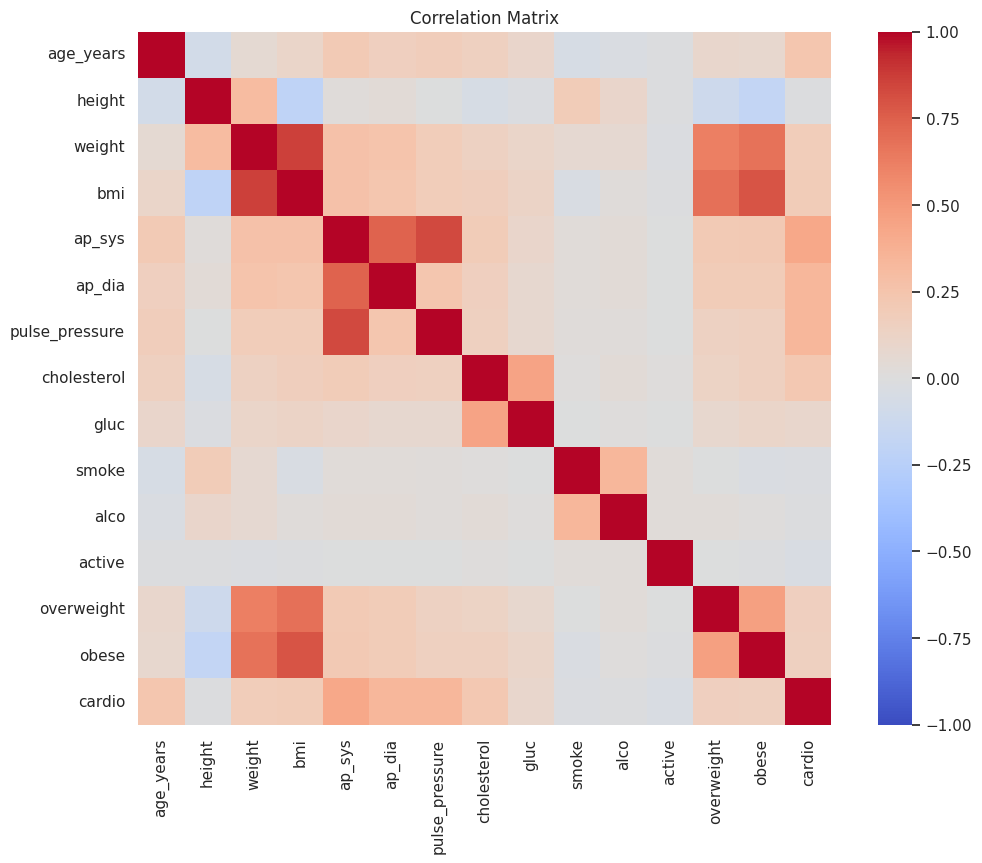

,cardio
cardio,1.000000
ap_sys,0.428058
ap_dia,0.340158
pulse_pressure,0.336779
age_years,0.239354
cholesterol,0.221417
bmi,0.189544
weight,0.180086
overweight,0.156383
obese,0.155058


In [ ]:
# Choose features for correlation (exclude IDs and raw 'age' in days to avoid dominating)
corr_cols = ['age_years', 'height', 'weight', 'bmi', 'ap_sys', 'ap_dia', 'pulse_pressure',
             'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'overweight', 'obese', 'cardio']

corr = df[corr_cols].corr()
plt.figure(figsize=(12, 9))
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0, vmin=-1, vmax=1, square=True)
plt.title("Correlation Matrix")
plt.show()

corr['cardio'].sort_values(ascending=False)


In [ ]:
# Feature set & target
FEATURES = [
    'age_years', 'height', 'weight', 'bmi',
    'ap_sys', 'ap_dia', 'pulse_pressure',
    'cholesterol', 'gluc', 'smoke', 'alco', 'active',
    'overweight', 'obese'
]
TARGET = 'cardio'

X = df[FEATURES].copy()
y = df[TARGET].copy()

# Train/validation split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Numerical vs categorical for scaling
num_cols = ['age_years','height','weight','bmi','ap_sys','ap_dia','pulse_pressure']
cat_cols = ['cholesterol','gluc','smoke','alco','active','overweight','obese']

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", "passthrough", cat_cols),
    ]
)


In [ ]:
# Many versions of this dataset are ~50/50, but we show SMOTE setup if needed for experimentation.
# We'll only apply SMOTE inside pipelines where appropriate (to avoid leakage).
from imblearn.pipeline import Pipeline as ImbPipeline

def make_pipeline(estimator, use_smote=False):
    if use_smote:
        return ImbPipeline(steps=[("pre", preprocess),
                                  ("smote", SMOTE(random_state=RANDOM_STATE)),
                                  ("clf", estimator)])
    else:
        return Pipeline(steps=[("pre", preprocess),
                               ("clf", estimator)])


In [ ]:
models = {
    "LogisticRegression": make_pipeline(
        LogisticRegression(max_iter=500, n_jobs=None, class_weight=None, random_state=RANDOM_STATE),
        use_smote=False
    ),
    "SVM (RBF)": make_pipeline(SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE), use_smote=False),
    "KNN": make_pipeline(KNeighborsClassifier(), use_smote=False),
    "DecisionTree": make_pipeline(DecisionTreeClassifier(random_state=RANDOM_STATE), use_smote=False),
    "RandomForest": make_pipeline(RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE), use_smote=False),
}

results = []
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe[-1], "predict_proba") else None

    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec  = recall_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)
    roc  = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

    results.append([name, acc, prec, rec, f1, roc])

res_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1", "ROC_AUC"]).sort_values("Accuracy", ascending=False)
display(res_df)


,Model,Accuracy,Precision,Recall,F1,ROC_AUC
1,SVM (RBF),0.736593,0.767713,0.670349,0.715735,0.791426
0,LogisticRegression,0.730545,0.758315,0.668287,0.710460,0.792271
4,RandomForest,0.713203,0.712245,0.705111,0.708660,0.769954
2,KNN,0.697829,0.698408,0.684932,0.691604,0.745595
3,DecisionTree,0.632469,0.628102,0.630137,0.629118,0.631876


In [ ]:
# Parameter grids (using clf__ since final step name is clf)
param_grids = {
    "RandomForest": {
        "clf__n_estimators": [200, 300],
        "clf__max_depth": [None, 12],
        "clf__min_samples_split": [2, 5],
        "clf__min_samples_leaf": [1, 2],
    },
    "LogisticRegression": {
        "clf__penalty": ["l2"],
        "clf__C": [0.5, 1.0],
        "clf__solver": ["lbfgs", "liblinear"],
    },
    "SVM (RBF)": {
        "clf__C": [1, 2],
        "clf__gamma": ["scale", 0.1]
    }
}

best_models = {}
for name, pipe in models.items():
    if name not in param_grids:
        continue

    print(f"\nTuning {name}...")

    # For SVM, use a smaller subset for speed
    if name == "SVM (RBF)":
        X_sub, _, y_sub, _ = train_test_split(
            X_train, y_train,
            train_size=0.2, stratify=y_train,
            random_state=42
        )
        grid = GridSearchCV(pipe, param_grids[name], scoring='accuracy', cv=3, n_jobs=-1, verbose=1)
        grid.fit(X_sub, y_sub)
    else:
        grid = GridSearchCV(pipe, param_grids[name], scoring='accuracy', cv=3, n_jobs=-1, verbose=1)
        grid.fit(X_train, y_train)

    print("Best params:", grid.best_params_)
    print("CV best accuracy:", grid.best_score_)
    best_models[name] = grid.best_estimator_

# Evaluate tuned models on test set
tuned_results = []
for name, est in best_models.items():
    y_pred = est.predict(X_test)
    y_proba = est.predict_proba(X_test)[:, 1] if hasattr(est[-1], "predict_proba") else None
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec  = recall_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)
    roc  = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
    tuned_results.append([name + " (tuned)", acc, prec, rec, f1, roc])

tuned_df = pd.DataFrame(
    tuned_results,
    columns=["Model", "Accuracy", "Precision", "Recall", "F1", "ROC_AUC"]
).sort_values("Accuracy", ascending=False)

display(tuned_df)



Tuning LogisticRegression...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params: {'clf__C': 1.0, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
CV best accuracy: 0.7259395675638608

Tuning SVM (RBF)...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params: {'clf__C': 1, 'clf__gamma': 0.1}
CV best accuracy: 0.7300047640595762

Tuning RandomForest...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best params: {'clf__max_depth': 12, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 300}
CV best accuracy: 0.7323884533702191


,Model,Accuracy,Precision,Recall,F1,ROC_AUC
2,RandomForest (tuned),0.736447,0.761113,0.680954,0.718806,0.802215
1,SVM (RBF) (tuned),0.734261,0.758388,0.679187,0.716606,0.791935
0,LogisticRegression (tuned),0.730399,0.758234,0.667992,0.710258,0.792253


,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,SVM (RBF),0.736593,0.767713,0.670349,0.715735,0.791426
5,RandomForest (tuned),0.736447,0.761113,0.680954,0.718806,0.802215
6,SVM (RBF) (tuned),0.734261,0.758388,0.679187,0.716606,0.791935
1,LogisticRegression,0.730545,0.758315,0.668287,0.710460,0.792271
7,LogisticRegression (tuned),0.730399,0.758234,0.667992,0.710258,0.792253
2,RandomForest,0.713203,0.712245,0.705111,0.708660,0.769954
3,KNN,0.697829,0.698408,0.684932,0.691604,0.745595
4,DecisionTree,0.632469,0.628102,0.630137,0.629118,0.631876


Best model by Accuracy: SVM (RBF)
              precision    recall  f1-score   support

           0       0.71      0.80      0.75      6935
           1       0.77      0.67      0.72      6789

    accuracy                           0.74     13724
   macro avg       0.74      0.74      0.74     13724
weighted avg       0.74      0.74      0.74     13724



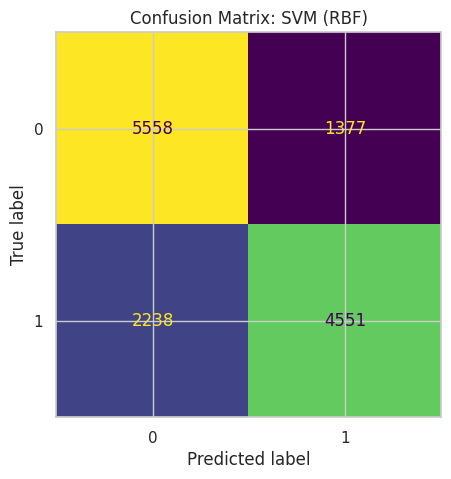

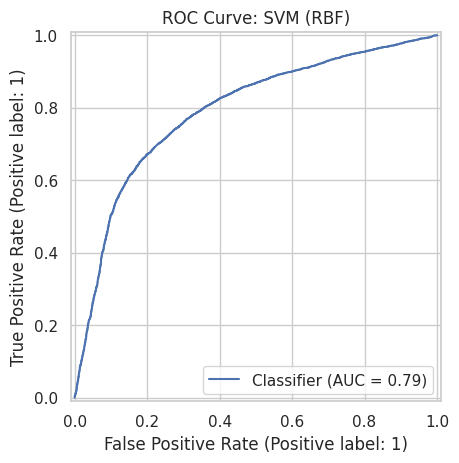

In [ ]:
# Combine and choose best by Accuracy (or F1/ROC_AUC if you prefer)
combined = pd.concat([res_df, tuned_df], ignore_index=True)
combined = combined.sort_values("Accuracy", ascending=False)
display(combined.head(10))

best_name = combined.iloc[0]["Model"]
print("Best model by Accuracy:", best_name)

# Retrieve the best fitted estimator
if "(tuned)" in best_name:
    base_name = best_name.replace(" (tuned)", "")
    best_estimator = best_models[base_name]
else:
    best_estimator = models[best_name]

# Classification report & confusion matrix
y_pred = best_estimator.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, colorbar=False)
ax.set_title(f"Confusion Matrix: {best_name}")
plt.show()

# ROC curve
if hasattr(best_estimator[-1], "predict_proba"):
    y_proba = best_estimator.predict_proba(X_test)[:, 1]
    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.title(f"ROC Curve: {best_name}")
    plt.show()


In [ ]:
# Refit best model on the full dataset (train+test) for deployment
final_model = best_estimator
final_model.fit(X, y)

# Save artifacts
os.makedirs("artifacts", exist_ok=True)
model_path = "artifacts/heart_disease_model.joblib"
joblib.dump(final_model, model_path)

features_path = "artifacts/feature_list.txt"
with open(features_path, "w") as f:
    f.write("\n".join(FEATURES))

print("Saved model to:", model_path)
print("Saved feature list to:", features_path)


Saved model to: artifacts/heart_disease_model.joblib
Saved feature list to: artifacts/feature_list.txt


In [ ]:
# Example: make a single-row prediction
example = pd.DataFrame([{
    'age_years': 54, 'height': 165, 'weight': 78,
    'bmi': 78 / (1.65**2),
    'ap_sys': 145, 'ap_dia': 92, 'pulse_pressure': 145-92,
    'cholesterol': 2, 'gluc': 1, 'smoke': 0, 'alco': 0, 'active': 1,
    'overweight': int((78 / (1.65**2)) >= 25),
    'obese': int((78 / (1.65**2)) >= 30)
}])[FEATURES]

pred_proba = final_model.predict_proba(example)[:, 1][0] if hasattr(final_model[-1], "predict_proba") else None
pred_class = final_model.predict(example)[0]

print("Predicted class (1=cardio disease, 0=no):", int(pred_class))
if pred_proba is not None:
    print("Predicted probability of disease:", round(float(pred_proba), 4))


Predicted class (1=cardio disease, 0=no): 1
Predicted probability of disease: 0.8324
